In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit_nature.drivers import Molecule
from qiskit.circuit.library import TwoLocal

from quantum_serverless import QuantumServerless
from quantum_serverless.library.groundstate_sweep import groundstate_solver_parallel_sweep

### Initialization

In [2]:
# default initialization
serverless = QuantumServerless()

# from configuration object
config = {"providers": [{"name": "ibm"}]}
serverless = QuantumServerless(config)

# from config file
serverless = QuantumServerless.load_configuration("./serverless_config.json")

serverless

<QuantumServerless: providers [local, ibm], clusters [local, ibm_remote]>

In [3]:
# get available providers
serverless.providers()

[<Provider: local>, <Provider: ibm>]

In [4]:
# get available clusters
serverless.clusters()

[<Cluster: local>, <Cluster: ibm_remote>]

In [5]:
# get available backends
backends = serverless.backends()

backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

### Grounstate solver sweep

![parameter sweep](images/parameter_sweep.png)

In [6]:
# help(groundstate_solver_parallel_sweep)

In [7]:
ibmq_qasm_sim = backends[0]

ibmq_qasm_sim

<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>

In [15]:
%%capture

with serverless:  # or serverless.provider("ibm")
    results = groundstate_solver_parallel_sweep(
        molecules=[
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.635]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.535]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.435]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.335]]], charge=0, multiplicity=1)
        ],
        # ansatz=[
        #     TwoLocal(rotation_blocks=["h", "rx"], entanglement_blocks="cz", entanglement="full", reps=2, parameter_prefix="y"),
        #     TwoLocal(rotation_blocks=["h", "rx"], entanglement_blocks="cz", entanglement="full", reps=1, parameter_prefix="y")
        # ]
        # backends=[ibmq_qasm_sim]
    )

In [16]:
# print results
for sweep in results[:1]:
    print("")
    print(sweep.parameters["molecule"]) # run parameters
    print("---")
    print(sweep.result) # run result


Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		H	[0.0, 0.0, 0.0]
		H	[0.0, 0.0, 0.735]
---
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857272868858
  - computed part:      -1.857272868858
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137303874409
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38985834]
    - computed part:      [0.0  0.0  1.38985834]
  > Dipole moment (a.u.): [0.0  0.0  -0.00090964]  Total: 0.00090964
                 (debye): [0.0  0.0  -0.00231207]  Total: 0.00231207
 


### Example with large range of molecules

In [17]:
%%capture

with serverless:
    results = groundstate_solver_parallel_sweep(
        molecules=[
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, length]]], charge=0, multiplicity=1)
            for length in np.arange(0.2, 0.9, 0.01)
        ]
    )

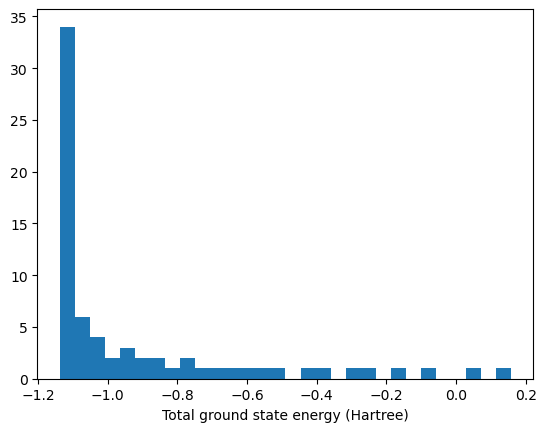

In [18]:
energies = [sweep.result.groundenergy + sweep.result.nuclear_repulsion_energy for sweep in results]

plt.hist(energies, bins=30)
plt.xlabel("Total ground state energy (Hartree)")

plt.show()

In [19]:
# # print results
# for sweep in results:
#     print("")
#     print(sweep.parameters["molecule"]) # run parameters
#     print("---")
#     print(sweep.result) # run result

### Sourcecode sneak peek

```python
from quantum_serverless import QuantumServerless, run_qiskit_remote, get


@run_qiskit_remote(target={"cpu": 2})
def ground_state_solve(
    backend: Backend,
    molecule: Molecule,
    ansatz: Optional[QuantumCircuit] = None,
):
    ...


def groundstate_solver_parallel_sweep(
    molecules: Union[List[Molecule], List[List[str]]],
    backends: Optional[List[Backend]] = None,
    geometries: Optional[List[List[List[float]]]] = None,
    ansatz: Optional[List[QuantumCircuit]] = None,
    n_geometries: Optional[int] = None
):
    ...
    references = [
        ground_state_solve(**trial)
        for trail in trials
    ]
    return [
        SweepResult(result, parameters)
        for result, parameters in zip(get(references), trials)
    ]
```